In [ ]:
import requests
import pandas as pd
import numpy as np
# import config
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.metrics import precision_recall_curve
import math
import scipy.stats as st
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
url = 'https://api.coingecko.com/api/v3/coins/cardano/market_chart?vs_currency=usd&days=1200'
response = requests.get(url)
data = response.json()

In [ ]:
df = pd.DataFrame(data['prices'], columns=['date', 'close'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df.set_index('date', inplace=True)
#df.to_csv('shiba-inu.csv', index=False)

In [ ]:
df

,close
date,
2020-01-05 00:00:00,0.034298
2020-01-06 00:00:00,0.034427
2020-01-07 00:00:00,0.036999
2020-01-08 00:00:00,0.037000
2020-01-09 00:00:00,0.036225
...,...
2023-04-15 00:00:00,0.438920
2023-04-16 00:00:00,0.454158
2023-04-17 00:00:00,0.451766


In [ ]:
def visualization1(df, chart_title):
    #plt.plot(df['close'],label="Close price")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df['close'], name='Close price'))
    fig.update_layout(
    title=chart_title,
    xaxis_title="Date",
    yaxis_title="Close price", width=1350, height=500
    )
    fig.show()

In [ ]:
def data_engineering(df):
    train_size =int(len(df)*0.80)
    train, test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
    print(train.shape, test.shape)

    scaler = StandardScaler()
    scaler = scaler.fit(train[['close']])
    train['close']= scaler.transform(train[["close"]])
    test['close']= scaler.transform(test[["close"]])
    train.head()
    return train,test,scaler

In [ ]:
def create_dataset(X,y,time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
def train_test_split(train,test,TIME_STEPS):

    x_train,y_train = create_dataset(train[["close"]],train.close,TIME_STEPS)
    x_test,y_test = create_dataset(test[["close"]],test.close,TIME_STEPS)
    return x_train,x_test,y_train,y_test

In [ ]:
def get_model():
    model= keras.Sequential()

    model.add(keras.layers.LSTM(units=128,input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.RepeatVector(n=x_train.shape[1]))
    model.add(keras.layers.LSTM(units=64,return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=x_train.shape[2])))

    model.compile(loss='mae',optimizer ='adam')

    return model

In [ ]:
def visualization2(train_mse_loss):

#    sns.distplot(train_mse_loss,bins=50,kde=True,ax = axs)
    fig = px.histogram(train_mse_loss, nbins=50, histnorm='probability density')
    fig.update_layout(xaxis_title='Loss', yaxis_title='Density', title='Distribution of Train MSE Loss', width=1350, height=500)
    fig.show()

In [ ]:
def visualization3(test_score_df):
#    sns.lineplot(x= test_score_df.index, y= test_score_df.loss,label='loss',ax = axs)
#    sns.lineplot(x = test_score_df.index, y =test_score_df.threshold,label='threshold',ax = axs)
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df.loss, mode='lines', name='loss'))
    fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df.threshold, mode='lines', name='threshold'))

    fig.update_layout(title='Test Loss vs Threshold', xaxis_title='Date', yaxis_title='Loss', width=1350, height=500)
    fig.show()

In [ ]:
def display_actual_predicted(df, predictions, title):
    fig = go.Figure()

    # Actual line plot
    fig.add_trace(go.Scatter(x=df.index, y=df.values.reshape(-1), mode='lines', name='Actual'))

    # Predicted line plot
    fig.add_trace(go.Scatter(x=df.index, y=predictions.reshape(-1), mode='lines', name='Predicted'))

    fig.update_layout(title=title, xaxis_title='Time', yaxis_title='Price', legend=dict(x=0, y=1, traceorder="normal"), width=1350, height=500)
    fig.show()

In [ ]:
def visualization4(test,anomalies,TIME_STEPS,scaler):
    fig = go.Figure()
# Line plot for Close price
    fig.add_trace(go.Scatter(x=test[TIME_STEPS:].index, 
    y=scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(1,-1)).reshape(-1),
    mode='lines', name='Close price'))

# Scatter plot for anomalies
    fig.add_trace(go.Scatter(x=anomalies.index, 
    y=scaler.inverse_transform(anomalies.close.values.reshape(1,-1)).reshape(-1),
    mode='markers', marker=dict(color='red', size=10),
    name='Anomaly'))
# Update layout
    fig.update_layout(title='Close price vs Anomalies',
    xaxis_title='Date',
    yaxis_title='Close price',
    legend=dict(x=0, y=1, traceorder="normal"), width=1350, height=500)

    fig.show()

In [ ]:
def visualization5(df):
   # fig = go.Figure()
   # fig.add_trace(go.Scatter(x=test.index[TIME_STEPS:], y=test[TIME_STEPS:].close, name='Actual'))
   # fig.add_trace(go.Scatter(x=test.index[TIME_STEPS:], y=x_test_pred[:, -1], name='Predicted'))
   # fig.update_layout(title='Actual vs Predicted Prices', xaxis_title='Date', yaxis_title='Price')
   # fig.update_xaxes(type='category')
   # fig.show()

   # fig = go.Figure()

    fig, ax = plt.subplots(figsize=(17,5))
    ax.plot(test.index[TIME_STEPS:], test[TIME_STEPS:].close, label='Actual')
    ax.plot(test.index[TIME_STEPS:], x_test_pred[:, -1], label='Predicted')
    ax.legend()
    ax.set_title('Actual vs Predicted Prices')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
   

In [ ]:
visualization1(df, "Cardano Price History")

Start
1
(960, 1) (241, 1)
2
3


<ipython-input-38-49ca1806ba9f>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-49ca1806ba9f>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_7 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            65        
 tributed)                                            

Dataframe 3: MSE: 0.0044, RMSE: 0.0664, MAE: 0.0519, F1 Score: 1.0000, Number of Anomalies: 13.0000
Finish


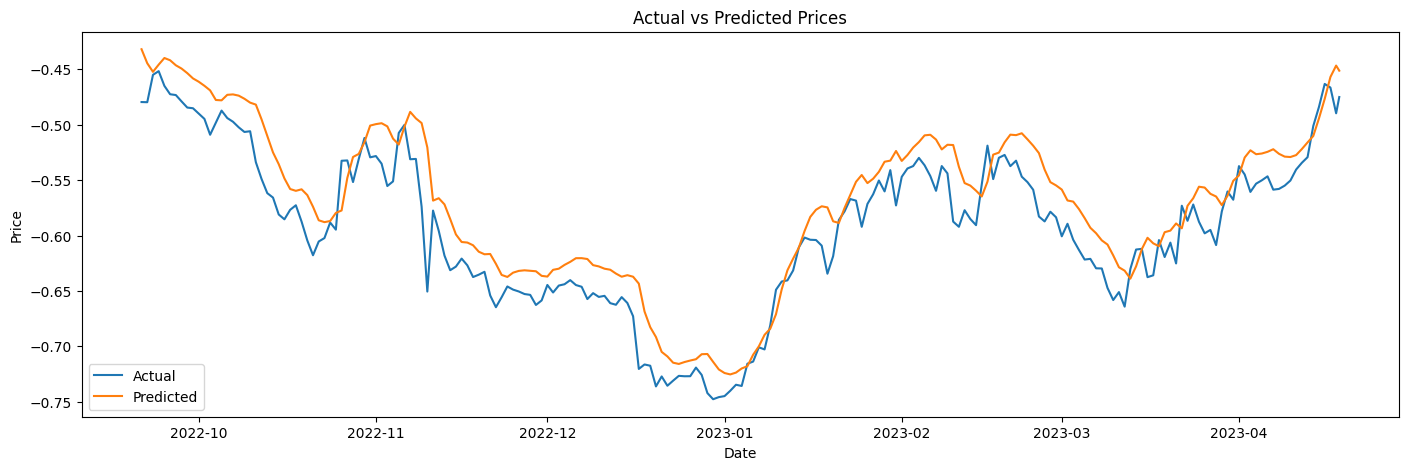

In [ ]:
list_df = [df]
TIME_STEPS = 30
i = 0

for df in list_df: 
    print('Start')

    df = df[['close']]
    
    print(1)

    train, test, scaler = data_engineering(df)
    print(2)

    x_train, x_test, y_train, y_test = train_test_split(train, test, TIME_STEPS)
    print(3)

    model = get_model()
    model.summary()
    print(4)

    #Dataframe 3: MSE: 0.0038, RMSE: 0.0613, MAE: 0.0466, F1 Score: 1.0000, Number of Anomalies: 11.0000
    #Dataframe 3: MSE: 0.0040, RMSE: 0.0629, MAE: 0.0480, F1 Score: 1.0000, Number of Anomalies: 13.0000
    history = model.fit(x_train, y_train, epochs=30, batch_size=16, validation_split=0.1, shuffle=False)
    x_train_pred = model.predict(x_train)

    train_mse_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    x_test_pred = model.predict(x_test)
    visualization2(train_mse_loss)
    i += 1

    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    THRESHOLD = np.percentile(test_mae_loss, 94)

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['close'] = test[TIME_STEPS:].close

    anomalies = test_score_df[test_score_df.anomaly == True]
    anomalies.head()

    visualization3(test_score_df)
    i += 1

    # Display actual and predicted prices
    visualization5(df)

    visualization4(test, anomalies, TIME_STEPS, scaler)
    i += 1

    #visualization5(test, x_test_pred, scaler)
    


    # Calculate MSE and RMSE
    mse = np.mean(np.square(x_test_pred - x_test))
    rmse = np.sqrt(mse)

    # Calculate F1 score
    precision, recall, thresholds = precision_recall_curve(test_score_df['anomaly'], test_score_df['loss'])
    f1_score = 2 * (precision * recall) / (precision + recall)
    best_f1_score = np.max(f1_score)

    mae = np.mean(np.abs(x_test_pred - x_test))
    std_dev = np.std(test_mae_loss)
    num_anomalies = len(anomalies)

    print(f'Dataframe {i}: MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, F1 Score: {best_f1_score:.4f}, Number of Anomalies: {num_anomalies:.4f}')


    i += 1
    print('Finish')